# Trabajo 2: Aspectos prácticos de las redes neuronales

En este segundo trabajo, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en el Tema 4.

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

In [1]:
# Puedes añadir todos los imports adicionales que necesites aquí
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import numpy as np
np.random.seed(4422)

from tensorflow import set_random_seed
set_random_seed(9090)

Using TensorFlow backend.


#### Obtención de los datos y pre-processing

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
x_train_full = x_train_full / 255.0
x_test = x_test / 255.0

In [3]:
# Split the training data into training and validataion
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, train_size=0.8, random_state=424242)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
from keras.utils import to_categorical

#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

#### **Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación **

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

*model = Sequential()*

*model.add(lo que sea)  # Definición del modelo*

*model.fit()*

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

In [5]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(histories, names=[], title="Graph title", colors=['green', 'blue', 'red', 'yellow', 'magenta']):
    """Compare accuraccy between models"""
    legend = []
    for h, c in zip(histories, colors):
        plt.plot(h.history['acc'], color=c)
        plt.plot(h.history['val_acc'], 'r--', color=c)
        legend.append('Train %s' % h.model.name)
        legend.append('Val %s' % h.model.name)
        
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(legend, loc='lower right')
    plt.show()
    
# Nota: podéis cambiar los números aquí presentes y ejecutar esta línea si queréis cambiar el tamaño
# de las gráficas
# matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams['figure.figsize'] = [10, 10]

## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1**: Partiendo de una red sencilla como la desarrollada en el Trabajo 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.

*Pista: Usando redes más grandes se hace más sencillo apreciar las diferencias. Es mejor utilizar al menos 3 o 4 capas densas.*

In [6]:
## Tu código y comentarios de texto aquí
## Puedes incluir tantas celdas como quieras
## No olvides utilizar celdas de Markdown para texto

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

BS=64
ISIZE=28*28

# Define callbacks used to early stopping
#callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.02),]


def build_model(name, af='relu', kInit='glorot_uniform', optimizer='sgd'):
    """Helper function building a network and training it"""
    
    print('\n\nBuilding and training model %s with af=%s, kInit=%s, optimizer=%s ...' % (name, af, kInit, optimizer))
    model = Sequential()
    model.name = name
    
    model.add(Flatten())
    model.add(Dense(256, activation=af, input_shape=(ISIZE,), kernel_initializer=kInit))
    #model.add(Dropout(rate=0.5))
    model.add(Dense(128, activation=af, kernel_initializer=kInit))
    model.add(Dropout(rate=0.5))
    model.add(Dense(64, activation=af, kernel_initializer=kInit))
    #model.add(Dropout(rate=0.5))
    model.add(Dense(10, activation='softmax', kernel_initializer=kInit))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    # train model
    history = model.fit(x_train, y_train, epochs=40, batch_size=BS, verbose=2, validation_data=(x_val, y_val), callbacks=callbacks)
            
    return history, model



Building and training model sigmoid with af=sigmoid, kInit=glorot_uniform, optimizer=sgd ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/40
 - 17s - loss: 2.3138 - acc: 0.1072 - val_loss: 2.2882 - val_acc: 0.1012
Epoch 2/40
 - 3s - loss: 2.2931 - acc: 0.1238 - val_loss: 2.2694 - val_acc: 0.3066
Epoch 3/40
 - 3s - loss: 2.2715 - acc: 0.1475 - val_loss: 2.2402 - val_acc: 0.3193
Epoch 4/40
 - 3s - loss: 2.2325 - acc: 0.1865 - val_loss: 2.1807 - val_acc: 0.3780
Epoch 5/40
 - 3s - loss: 2.1476 - acc: 0.2370 - val_loss: 2.0435 - val_acc: 0.4447
Epoch 6/40
 - 3s - loss: 1.9792 - acc: 0.2835 - val_loss: 1.8291 - val_acc: 0.4548
Epoch 7/40
 - 3s - loss: 1.7950 - acc: 0.3340 - val_loss: 1.6701 - val_acc: 0.4622
Epoch 8/40
 - 3s - loss: 1.6638 - acc:

/usr/local/lib/python3.5/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 48000 samples, validate on 12000 samples
Epoch 1/40
 - 3s - loss: 0.9887 - acc: 0.6611 - val_loss: 0.6324 - val_acc: 0.7877
Epoch 2/40
 - 3s - loss: 0.6318 - acc: 0.7825 - val_loss: 0.5410 - val_acc: 0.8107
Epoch 3/40
 - 3s - loss: 0.5596 - acc: 0.8048 - val_loss: 0.4960 - val_acc: 0.8247
Epoch 4/40
 - 3s - loss: 0.5230 - acc: 0.8191 - val_loss: 0.4777 - val_acc: 0.8319
Epoch 5/40
 - 3s - loss: 0.4991 - acc: 0.8256 - val_loss: 0.4636 - val_acc: 0.8325
Epoch 6/40
 - 3s - loss: 0.4831 - acc: 0.8317 - val_loss: 0.4553 - val_acc: 0.8368
Epoch 7/40
 - 3s - loss: 0.4708 - acc: 0.8359 - val_loss: 0.4509 - val_acc: 0.8373


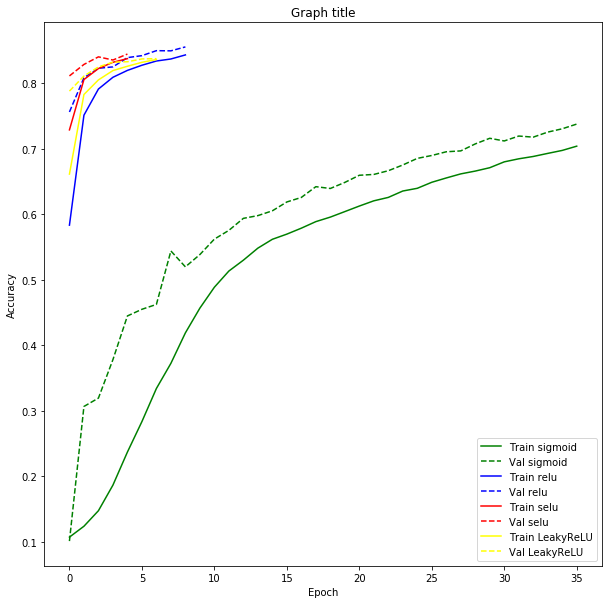

In [7]:
afs = ['sigmoid', 'relu', 'selu', keras.layers.LeakyReLU(alpha=0.5)]
names = ['sigmoid', 'relu', 'selu', 'LeakyReLU']
models = []
for af, name in zip(afs, names):
    h, m = build_model(name, af=af)
    models.append(h)
    
plot_compare_accs(models)

# Resultados
Se puede observar que las distintas variaciones de relu, consiguen resultados mejores y mucho más rapido que sigmoid

## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2**: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)



Building and training model zeros with af=relu, kInit=<keras.initializers.Zeros object at 0x7fc2cc32fdd8>, optimizer=sgd ...
Train on 48000 samples, validate on 12000 samples
Epoch 1/40
 - 3s - loss: 2.3026 - acc: 0.0973 - val_loss: 2.3026 - val_acc: 0.0993
Epoch 2/40
 - 3s - loss: 2.3026 - acc: 0.0970 - val_loss: 2.3026 - val_acc: 0.0986
Epoch 3/40
 - 3s - loss: 2.3026 - acc: 0.0981 - val_loss: 2.3026 - val_acc: 0.0986


Building and training model random_normal with af=relu, kInit=<keras.initializers.RandomNormal object at 0x7fc2cc313908>, optimizer=sgd ...
Train on 48000 samples, validate on 12000 samples
Epoch 1/40
 - 3s - loss: 1.9832 - acc: 0.2755 - val_loss: 1.2827 - val_acc: 0.5721
Epoch 2/40
 - 3s - loss: 1.0819 - acc: 0.5848 - val_loss: 0.8234 - val_acc: 0.6639
Epoch 3/40
 - 3s - loss: 0.8368 - acc: 0.6780 - val_loss: 0.7284 - val_acc: 0.7104
Epoch 4/40
 - 3s - loss: 0.7494 - acc: 0.7252 - val_loss: 0.6502 - val_acc: 0.7678
Epoch 5/40
 - 3s - loss: 0.6844 - acc: 0.7574 - va

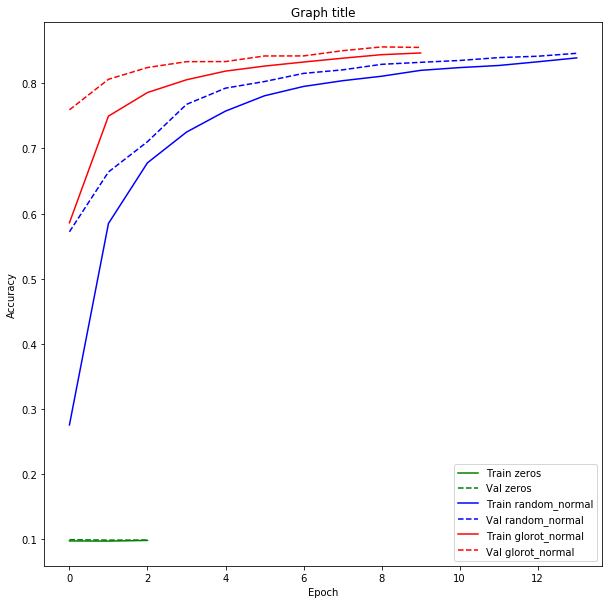

In [8]:
## Tu código y comentarios de texto aquí
## Puedes incluir tantas celdas como quieras
## No olvides utilizar celdas de Markdown para texto

kInits = [keras.initializers.Zeros(), keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), keras.initializers.glorot_normal(seed=None)]
names = ['zeros', 'random_normal', 'glorot_normal']

models = []
for kInit, name in zip(kInits, names):
    h, m = build_model(name, kInit=kInit)
    models.append(h)
    
plot_compare_accs(models)

# Resultados
La inicialización de los pesos tiene un gran efecto al la red.

Inicializar los pesos con un valor zero tiene un efecto catastropico.

## 3. Optimizadores

**Ejercicio 3**: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).



Building and training model SGD with af=relu, kInit=glorot_uniform, optimizer=sgd ...
Train on 48000 samples, validate on 12000 samples
Epoch 1/40
 - 3s - loss: 1.1791 - acc: 0.5978 - val_loss: 0.6847 - val_acc: 0.7641
Epoch 2/40
 - 3s - loss: 0.7098 - acc: 0.7531 - val_loss: 0.5619 - val_acc: 0.8031
Epoch 3/40
 - 3s - loss: 0.6076 - acc: 0.7896 - val_loss: 0.5023 - val_acc: 0.8218
Epoch 4/40
 - 3s - loss: 0.5553 - acc: 0.8085 - val_loss: 0.4920 - val_acc: 0.8208
Epoch 5/40
 - 3s - loss: 0.5228 - acc: 0.8174 - val_loss: 0.4544 - val_acc: 0.8383
Epoch 6/40
 - 3s - loss: 0.4957 - acc: 0.8289 - val_loss: 0.4422 - val_acc: 0.8417
Epoch 7/40
 - 3s - loss: 0.4768 - acc: 0.8345 - val_loss: 0.4295 - val_acc: 0.8441
Epoch 8/40
 - 3s - loss: 0.4630 - acc: 0.8399 - val_loss: 0.4189 - val_acc: 0.8495
Epoch 9/40
 - 3s - loss: 0.4498 - acc: 0.8424 - val_loss: 0.4281 - val_acc: 0.8438


Building and training model RMSprop with af=relu, kInit=glorot_uniform, optimizer=RMSprop ...
Train on 48000 samp

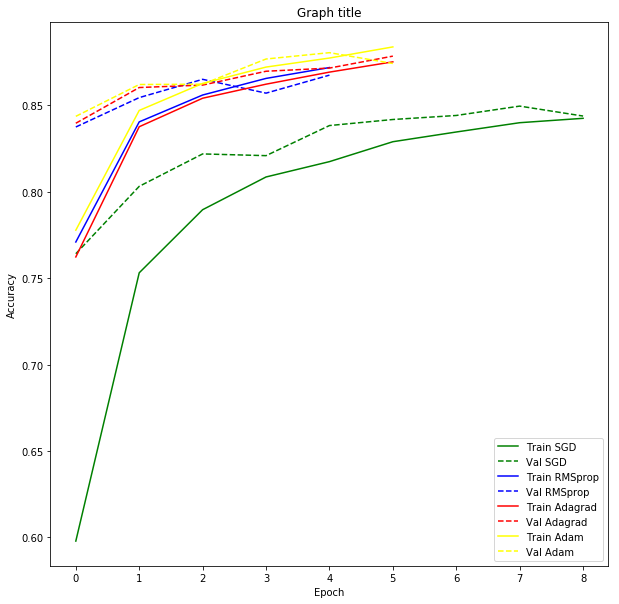

In [9]:
## Tu código y comentarios de texto aquí
## Puedes incluir tantas celdas como quieras
## No olvides utilizar celdas de Markdown para texto
optimizers = ['sgd', 'RMSprop', 'Adagrad', 'Adam']
names = ['SGD', 'RMSprop', 'Adagrad', 'Adam']

models = []
for name, optimizer in zip(names, optimizers):
    h, m = build_model(name, optimizer=optimizer)
    models.append(h)
    
plot_compare_accs(models)

# Resultados
SGD parece el optimizador más lento en comperación con los demás.

## 4. Regularización y red final

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

In [10]:
## Tu modelo y comentarios de texto aquí
## Puedes incluir tantas celdas como quieras
## No olvides utilizar celdas de Markdown para texto
from keras import regularizers

#regularizer=regularizers.l2(0.01)
regularizer=None
af='relu'
kInit='glorot_normal'
optimizer='adam'
optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01),]

model = Sequential()
model.name = name

model.add(Flatten())
model.add(Dense(256, activation=af, input_shape=(ISIZE,), kernel_initializer=kInit, kernel_regularizer=regularizer))
#model.add(Dropout(rate=0.5))
model.add(Dense(128, activation=af, kernel_initializer=kInit, kernel_regularizer=regularizer))
#model.add(Dropout(rate=0.5))
model.add(Dense(64, activation=af, kernel_initializer=kInit, kernel_regularizer=regularizer))
#model.add(Dropout(rate=0.5))
model.add(Dense(10, activation='softmax', kernel_initializer=kInit, kernel_regularizer=regularizer))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# train model
history = model.fit(x_train, y_train, epochs=40, batch_size=BS, verbose=2, validation_data=(x_val, y_val), callbacks=callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
 - 4s - loss: 0.5267 - acc: 0.8084 - val_loss: 0.4093 - val_acc: 0.8498
Epoch 2/40
 - 3s - loss: 0.3609 - acc: 0.8679 - val_loss: 0.3640 - val_acc: 0.8642
Epoch 3/40
 - 3s - loss: 0.3265 - acc: 0.8795 - val_loss: 0.3423 - val_acc: 0.8741
Epoch 4/40
 - 3s - loss: 0.3074 - acc: 0.8861 - val_loss: 0.3382 - val_acc: 0.8758
Epoch 5/40
 - 3s - loss: 0.2939 - acc: 0.8916 - val_loss: 0.3260 - val_acc: 0.8820
Epoch 6/40
 - 3s - loss: 0.2837 - acc: 0.8952 - val_loss: 0.3237 - val_acc: 0.8814
Epoch 7/40
 - 3s - loss: 0.2766 - acc: 0.8989 - val_loss: 0.3236 - val_acc: 0.8838


# Resultados
He probado muchas modificaciónes que casi todos producieron los mismos resultados. (# Neuronas, # Capas, ...)

Todos los métodos de regularización (dropout, L2, L1), producieron resultados peores.

Espero que vamos a ver durante la asignatura algunos consejos sobre como construier redes neuronales.

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

In [11]:
## Tu código y comentarios de texto aquí
score = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35109124109745027
Test accuracy: 0.876


# Resultados
Los resultados para test son muy parecidos a validation.